# GridSearchCV 적용 (Covid19 확진자 데이터)

## #01. 준비작업

### [1] 패키지 가져오기

In [113]:
import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *

import seaborn as sb
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from pandas import to_datetime, DatetimeIndex, Series, date_range, concat

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

import concurrent.futures as futures

### [2] 데이터 가져오기

In [92]:
origin = my_read_excel("https://data.hossam.kr/tsdata/covid19_seoul_230531.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   서울시 기준일            1212 non-null   object 
 1   서울시 확진자            1212 non-null   int64  
 2   서울시 추가 확진          1211 non-null   float64
 3   서울시 치료중            1212 non-null   int64  
 4   서울시 퇴원             770 non-null    float64
 5   서울시 추가 퇴원          770 non-null    float64
 6   서울시 사망             1212 non-null   int64  
 7   서울시 의심환자 전체        187 non-null    float64
 8   서울시 의심환자 검사중       188 non-null    float64
 9   서울시 의심환자 검사결과(음성)  188 non-null    float64
 10  전국 기준일             1212 non-null   object 
 11  전국 확진              1212 non-null   float64
 12  전국 추가 확진           1211 non-null   float64
 13  전국 치료중             1212 non-null   int64  
 14  전국 퇴원              770 non-null    float64
 15  전국 사망              1212 non-null   int64  
 16  전국 의심환자 전체         187 n

## #02. 데이터 전처리

### [1] 필요한 데이터만 추출

In [93]:
df = origin[['서울시 기준일', '서울시 추가 확진']]
my_pretty_table(df.head())

+----+-----------------+--------------------+
|    | 서울시 기준일   |   서울시 추가 확진 |
|----+-----------------+--------------------|
|  0 | 2023-05-31      |               5987 |
|  1 | 2023-05-30      |               3326 |
|  2 | 2023-05-29      |               1393 |
|  3 | 2023-05-28      |               1393 |
|  4 | 2023-05-27      |               4078 |
+----+-----------------+--------------------+


### [2] 결측치 처리

#### (1) 결측치 존재 확인

In [94]:
df.isna().sum()

서울시 기준일      0
서울시 추가 확진    1
dtype: int64

#### (2) 결측치 제거

In [95]:
df2 = df.fillna(0)
df2.isna().sum()

서울시 기준일      0
서울시 추가 확진    0
dtype: int64

### [3] 날짜 타입에 대한 형변환

```python
to_datetime(날짜필드, 형식문자열)
```

In [96]:
df2['서울시 기준일'] = to_datetime(df2['서울시 기준일'].str.strip(), format="%Y-%m-%d")
df2.dtypes

서울시 기준일      datetime64[ns]
서울시 추가 확진           float64
dtype: object

### [3] 컬럼이름 변경, 정렬, 인덱스 재설정

In [99]:
df3 = df2.rename(columns={"서울시 기준일": "ds", "서울시 추가 확진": "y"})
df3.sort_values('ds', inplace=True)
df3.reset_index(drop=True, inplace=True)
my_pretty_table(df3.head())

+----+---------------------+-----+
|    | ds                  |   y |
|----+---------------------+-----|
|  0 | 2020-02-05 00:00:00 |   0 |
|  1 | 2020-02-06 00:00:00 |   0 |
|  2 | 2020-02-07 00:00:00 |   0 |
|  3 | 2020-02-08 00:00:00 |   0 |
|  4 | 2020-02-09 00:00:00 |   0 |
+----+---------------------+-----+


## #03. 탐색적 데이터 분석

### [1] 날짜 컬럼을 인덱스로 설정

In [79]:
df4 = df3.set_index("ds")
df4.head()

,y
ds,
2020-02-05,0.0
2020-02-06,0.0
2020-02-07,0.0
2020-02-08,0.0
2020-02-09,0.0


### [2] ACF, PACF 플롯

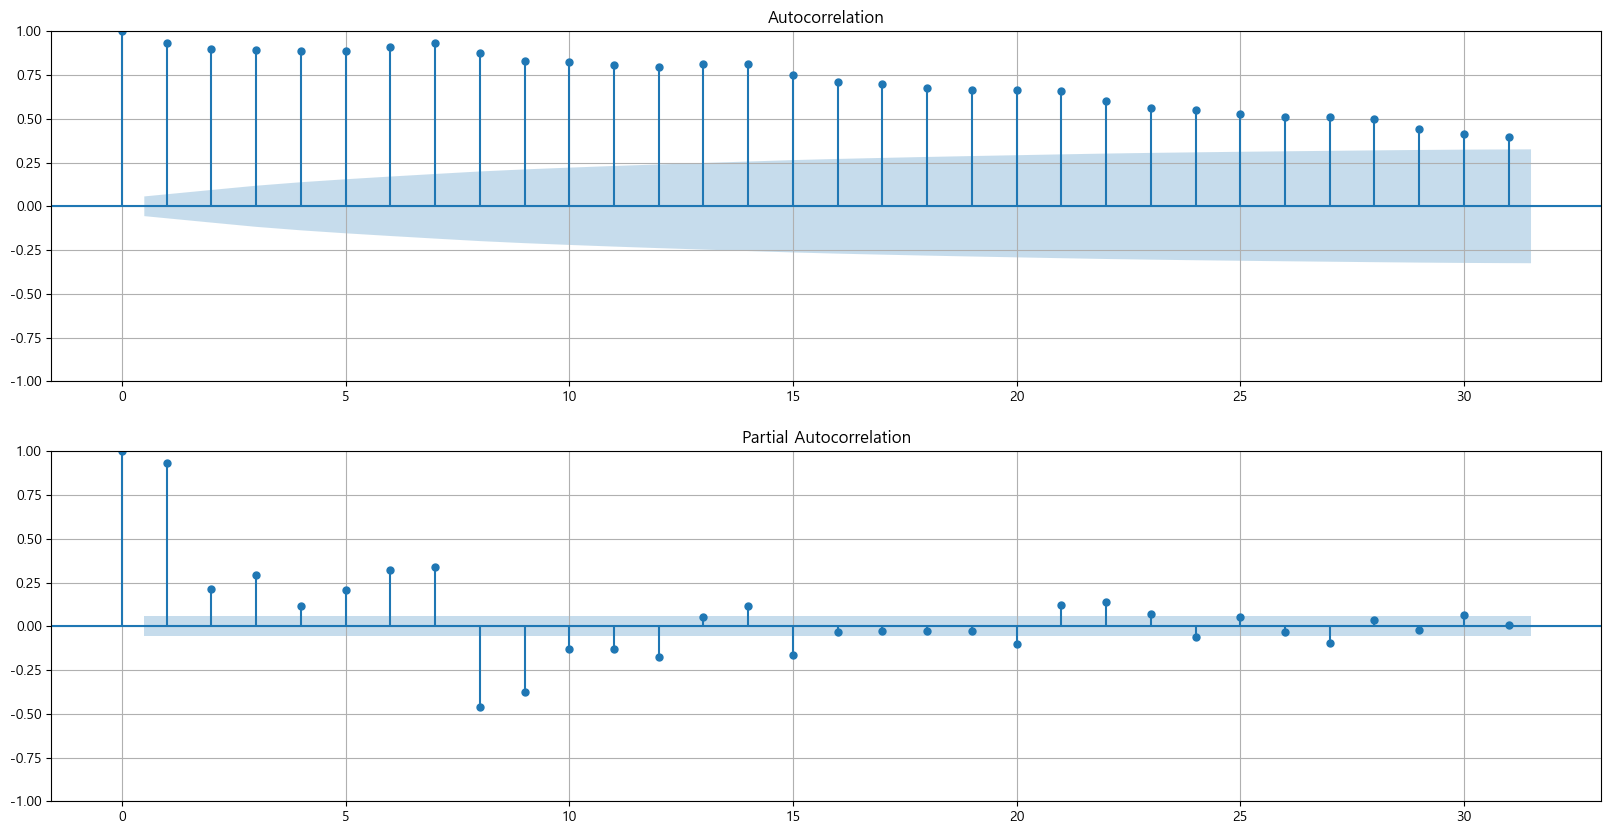

In [80]:
my_acf_pacf_plot(df4['y'], figsize=(20, 5))

### [3] 성분 분해

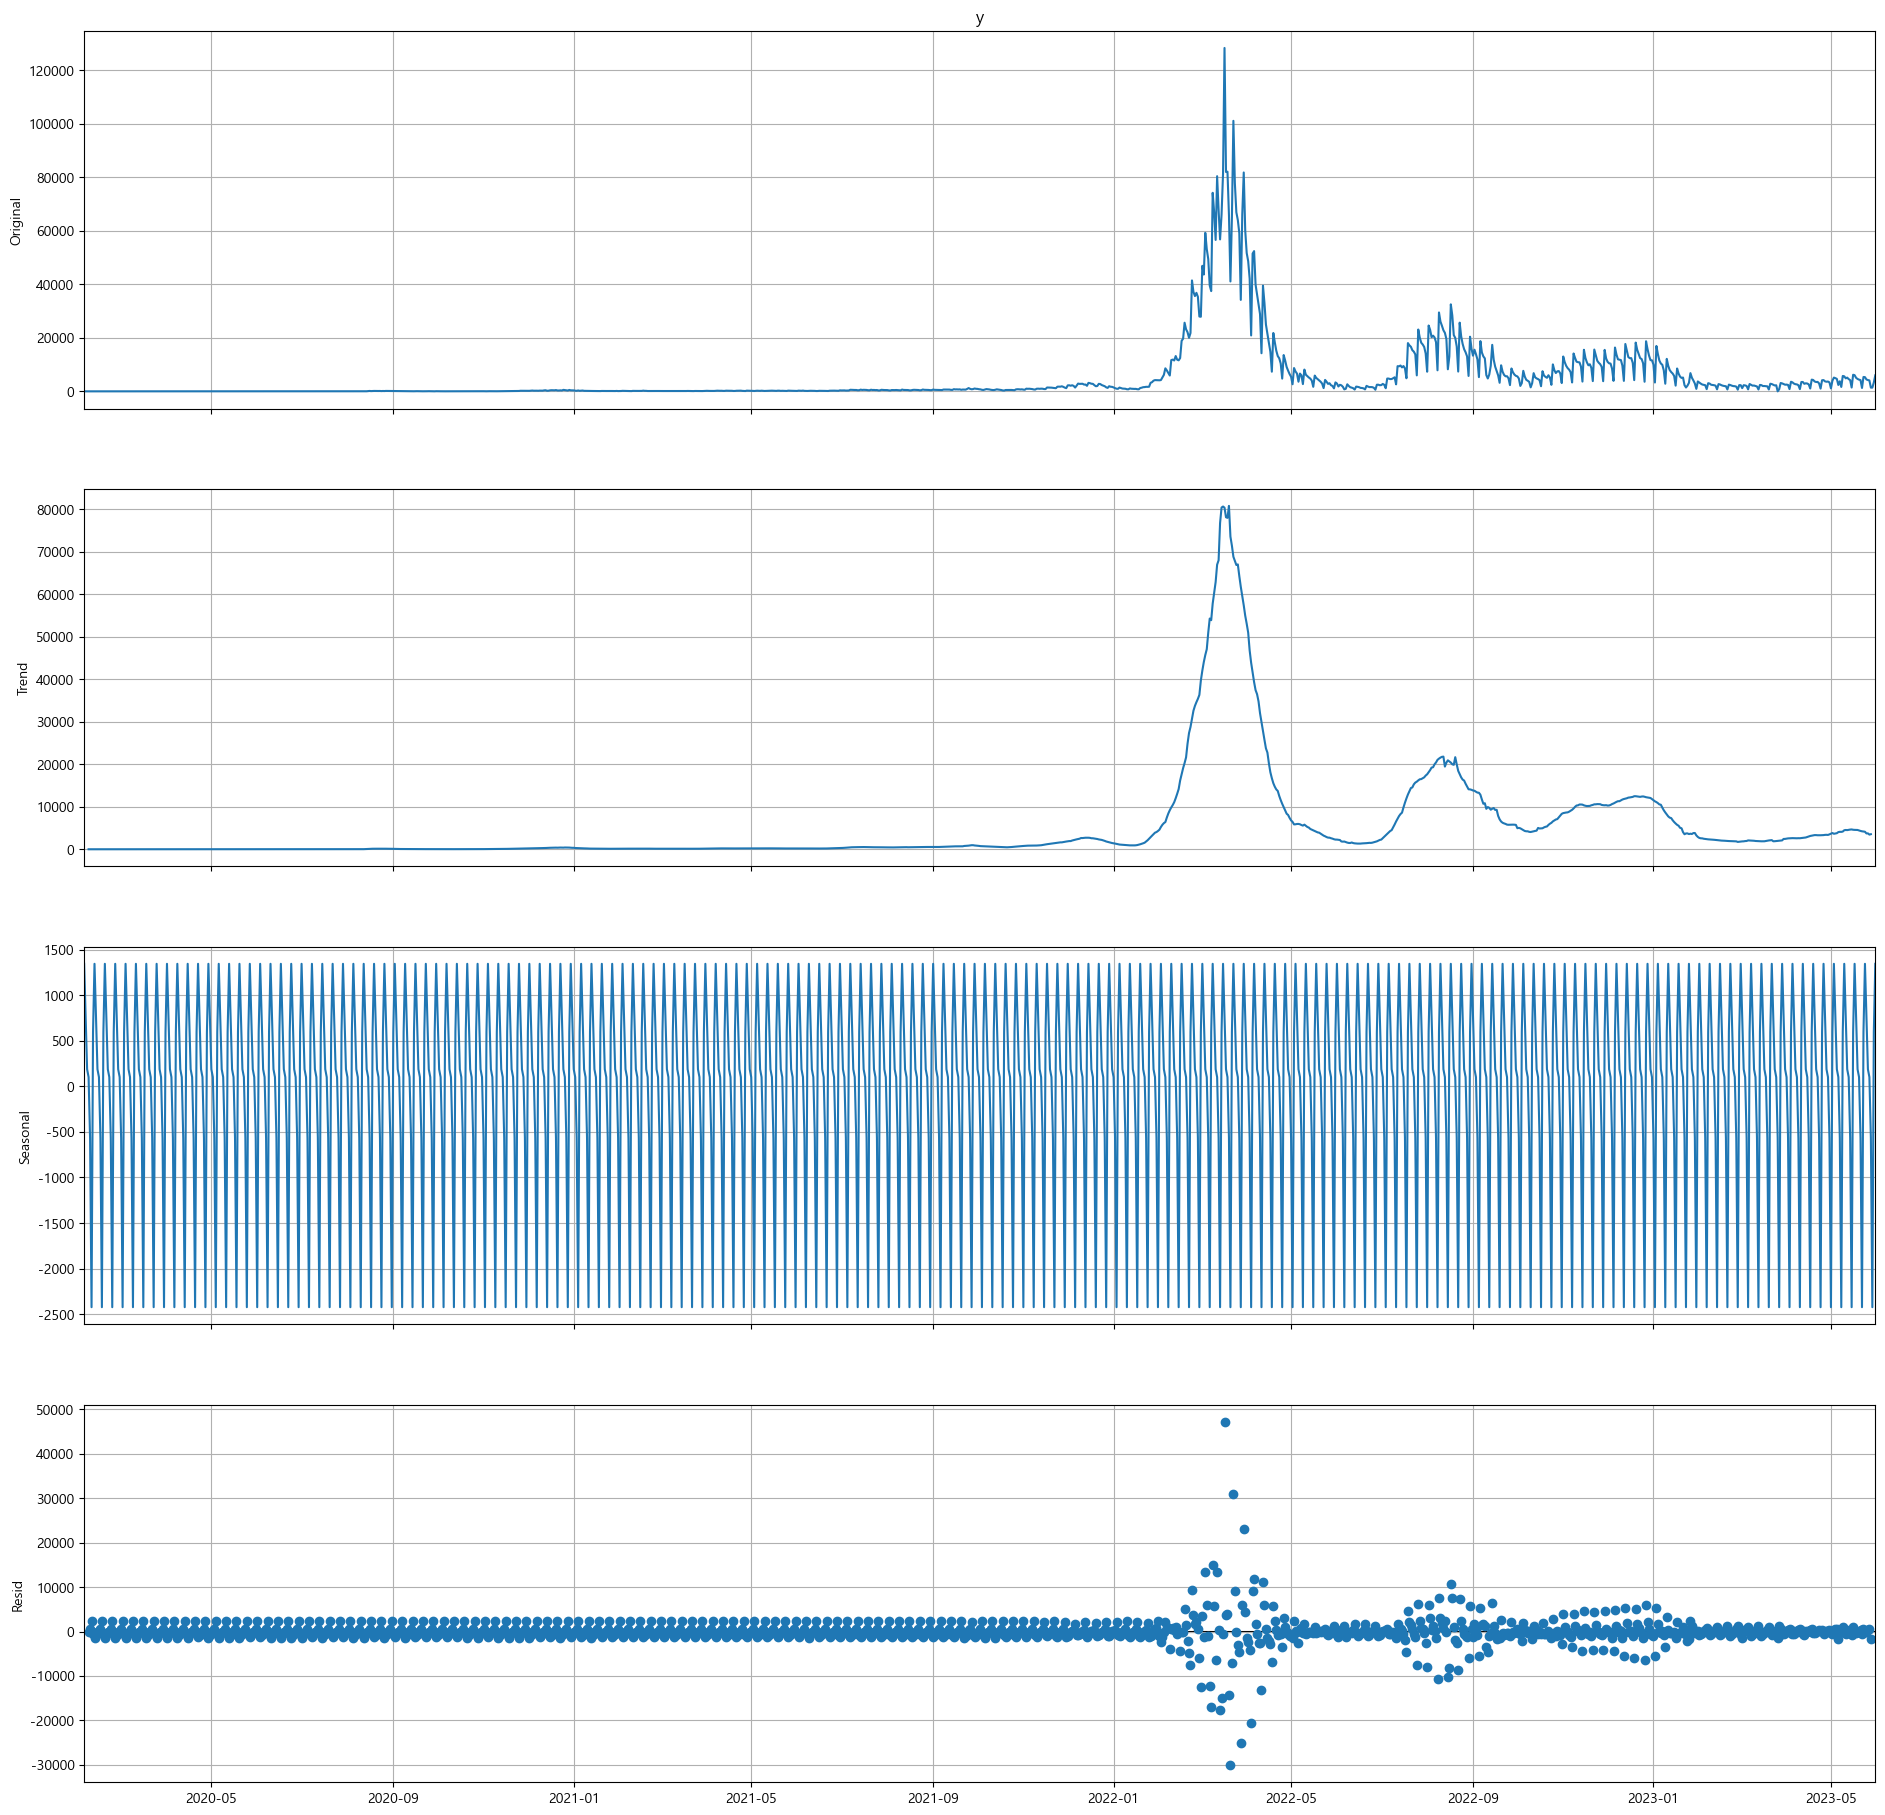

,original,trend,seasonal,resid
ds,,,,
2020-02-05,0.0,NaN,1343.186784,NaN
2020-02-06,0.0,NaN,763.326319,NaN
2020-02-07,0.0,NaN,186.890273,NaN
2020-02-08,0.0,0.000000,100.836008,-100.836008
2020-02-09,0.0,0.000000,-566.656973,566.656973
...,...,...,...,...
2023-05-27,4078.0,3450.571429,100.836008,526.592564
2023-05-28,1393.0,3547.000000,-566.656973,-1587.343027
2023-05-29,1393.0,NaN,-2422.726006,NaN


In [81]:
my_seasonal_decompose(df4['y'], figsize=(20, 5))

## #04. Prophet 분석 모델 구현

### [1] 튜닝하고자 하는 하이퍼 파라미터 정의

In [100]:
params = ParameterGrid({
    #'growth': ['linear', 'logistic'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'daily_seasonality':  [True, False],
    'yearly_seasonality': [True, False],
})

print('Total Possible Models', len(params))

Total Possible Models 144


### [2] 훈련, 검증 데이터 분리

In [101]:
train, test = my_timeseries_split(df3)
train.shape, test.shape

((969, 2), (243, 2))

### [3] GridSearchCV 구성

#### (1) 단순 반복 처리

In [109]:
%%time

for p in params:
    m = Prophet(**p)
    m.fit(train)

    future = m.make_future_dataframe(periods=len(test), freq='D')
    forecast = m.predict(future)
    #my_pretty_table(forecast)

    pred = forecast[['ds', 'yhat']][-len(test):]
    #print(pred)
    #print(test)
    score = np.sqrt(mean_squared_error(test['y'].values, pred['yhat'].values))
    print('RMSE ------------------------------------',score)

15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:05 - cmdstanpy - INFO - Chain [1] done processing
15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20109.97722617279


15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15498.102752418652


15:48:06 - cmdstanpy - INFO - Chain [1] start processing
15:48:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20168.12163804144


15:48:06 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15380.705700011351


15:48:06 - cmdstanpy - INFO - Chain [1] done processing
15:48:06 - cmdstanpy - INFO - Chain [1] start processing
15:48:07 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20293.04919652785


15:48:07 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15424.888412186025


15:48:07 - cmdstanpy - INFO - Chain [1] done processing
15:48:07 - cmdstanpy - INFO - Chain [1] start processing
15:48:07 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20854.967831169266


15:48:08 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15326.450665022352


15:48:08 - cmdstanpy - INFO - Chain [1] done processing
15:48:08 - cmdstanpy - INFO - Chain [1] start processing
15:48:08 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20725.61337169166


15:48:08 - cmdstanpy - INFO - Chain [1] start processing
15:48:08 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15282.059894352184


15:48:09 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 20875.43001435361


15:48:09 - cmdstanpy - INFO - Chain [1] done processing
15:48:09 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15598.21671867697


15:48:09 - cmdstanpy - INFO - Chain [1] done processing
15:48:09 - cmdstanpy - INFO - Chain [1] start processing
15:48:10 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 16767.223101683452


15:48:10 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15447.63418884731


15:48:10 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 16735.969527966525


15:48:10 - cmdstanpy - INFO - Chain [1] start processing
15:48:10 - cmdstanpy - INFO - Chain [1] done processing
15:48:11 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15520.63813371722


15:48:11 - cmdstanpy - INFO - Chain [1] done processing
15:48:11 - cmdstanpy - INFO - Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 64137.116595951906


15:48:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 16025.760766243442


15:48:12 - cmdstanpy - INFO - Chain [1] done processing
15:48:12 - cmdstanpy - INFO - Chain [1] start processing
15:48:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 60298.55513305942


15:48:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15462.996005661713


15:48:12 - cmdstanpy - INFO - Chain [1] done processing
15:48:13 - cmdstanpy - INFO - Chain [1] start processing
15:48:13 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 66785.58878308383


15:48:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 17125.324024372916


15:48:13 - cmdstanpy - INFO - Chain [1] done processing
15:48:14 - cmdstanpy - INFO - Chain [1] start processing
15:48:14 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 65525.4091707438


15:48:14 - cmdstanpy - INFO - Chain [1] start processing
15:48:14 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15454.218351008536


15:48:14 - cmdstanpy - INFO - Chain [1] start processing
15:48:14 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20331.014654557366


15:48:15 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15461.125361407097


15:48:15 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20317.007705775202


15:48:15 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15296.939507311334


15:48:16 - cmdstanpy - INFO - Chain [1] start processing
15:48:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20631.542577528005


15:48:16 - cmdstanpy - INFO - Chain [1] start processing
15:48:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15572.097484719614


15:48:16 - cmdstanpy - INFO - Chain [1] start processing
15:48:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20807.613627469673


15:48:17 - cmdstanpy - INFO - Chain [1] start processing
15:48:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15296.939507311334


15:48:17 - cmdstanpy - INFO - Chain [1] start processing
15:48:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20818.102838708506


15:48:17 - cmdstanpy - INFO - Chain [1] start processing
15:48:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15220.05117813281


15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 20852.163025444777


15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15296.939507311334


15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 16668.506122571907


15:48:19 - cmdstanpy - INFO - Chain [1] start processing
15:48:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15420.965307521807


15:48:19 - cmdstanpy - INFO - Chain [1] start processing
15:48:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 16551.788376726712


15:48:19 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15296.939507311334


15:48:20 - cmdstanpy - INFO - Chain [1] done processing
15:48:20 - cmdstanpy - INFO - Chain [1] start processing
15:48:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 67240.03070339169


15:48:20 - cmdstanpy - INFO - Chain [1] start processing
15:48:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 15713.442650594992


15:48:21 - cmdstanpy - INFO - Chain [1] start processing
15:48:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 68379.91475615161


15:48:21 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15296.939507311334


15:48:21 - cmdstanpy - INFO - Chain [1] done processing
15:48:21 - cmdstanpy - INFO - Chain [1] start processing
15:48:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 66441.876592229


15:48:22 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15973.467088943129


15:48:22 - cmdstanpy - INFO - Chain [1] done processing
15:48:22 - cmdstanpy - INFO - Chain [1] start processing
15:48:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 66617.41899380159


15:48:22 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 15296.939507311334


15:48:23 - cmdstanpy - INFO - Chain [1] done processing
15:48:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 17829.95680946111


15:48:23 - cmdstanpy - INFO - Chain [1] done processing
15:48:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25189.074520545622


15:48:23 - cmdstanpy - INFO - Chain [1] done processing
15:48:24 - cmdstanpy - INFO - Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 18419.93828273909


15:48:24 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25811.593065368506


15:48:24 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 11785.441838101364


15:48:25 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 24778.435405610926


15:48:25 - cmdstanpy - INFO - Chain [1] done processing
15:48:26 - cmdstanpy - INFO - Chain [1] start processing
15:48:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 11477.658426291038


15:48:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 22403.51365100987


15:48:26 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 12201.223336286645


15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25433.16109241263


15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 12717.336891173582


15:48:28 - cmdstanpy - INFO - Chain [1] done processing
15:48:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 24661.694710726257


15:48:28 - cmdstanpy - INFO - Chain [1] done processing
15:48:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 27582.6918444967


15:48:28 - cmdstanpy - INFO - Chain [1] done processing
15:48:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26635.651172854898


15:48:29 - cmdstanpy - INFO - Chain [1] done processing
15:48:29 - cmdstanpy - INFO - Chain [1] start processing
15:48:29 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 27039.324968514826


15:48:30 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25257.53247267901


15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:30 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 7625.939419565917


15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 29813.133667521484


15:48:31 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 68049.12797538776


15:48:31 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 29636.759964666293


15:48:32 - cmdstanpy - INFO - Chain [1] done processing
15:48:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 18844.30673926526


15:48:33 - cmdstanpy - INFO - Chain [1] done processing
15:48:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 33400.6625843483


15:48:33 - cmdstanpy - INFO - Chain [1] done processing
15:48:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 68260.1895332253


15:48:34 - cmdstanpy - INFO - Chain [1] done processing
15:48:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32840.30099214191


15:48:34 - cmdstanpy - INFO - Chain [1] done processing
15:48:34 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 18288.99510557672


15:48:35 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26401.022827013738


15:48:35 - cmdstanpy - INFO - Chain [1] done processing
15:48:35 - cmdstanpy - INFO - Chain [1] start processing
15:48:35 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 17738.29734415933


15:48:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26114.062095455552


15:48:36 - cmdstanpy - INFO - Chain [1] done processing
15:48:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 12261.5288988291


15:48:36 - cmdstanpy - INFO - Chain [1] done processing
15:48:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26052.558934013006


15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 13324.296479931701


15:48:37 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26114.062095455552


15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:38 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 11430.791239045366


15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:38 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26117.00159752342


15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 11714.180106900089


15:48:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26114.062095455552


15:48:39 - cmdstanpy - INFO - Chain [1] done processing
15:48:40 - cmdstanpy - INFO - Chain [1] start processing
15:48:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 27751.170705688877


15:48:40 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26472.7069826658


15:48:40 - cmdstanpy - INFO - Chain [1] done processing
15:48:40 - cmdstanpy - INFO - Chain [1] start processing
15:48:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 27072.270218349662


15:48:41 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26114.062095455552


15:48:41 - cmdstanpy - INFO - Chain [1] done processing
15:48:41 - cmdstanpy - INFO - Chain [1] start processing
15:48:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 16083.937610290335


15:48:42 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26481.138343451632


15:48:42 - cmdstanpy - INFO - Chain [1] done processing
15:48:42 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 13111.759387768501


15:48:42 - cmdstanpy - INFO - Chain [1] done processing
15:48:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26114.062095455552


15:48:43 - cmdstanpy - INFO - Chain [1] done processing
15:48:43 - cmdstanpy - INFO - Chain [1] start processing
15:48:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 13089.442840412066


15:48:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25261.80306731997


15:48:44 - cmdstanpy - INFO - Chain [1] done processing
15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 71752.20100651949


15:48:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 26114.062095455552


15:48:45 - cmdstanpy - INFO - Chain [1] done processing
15:48:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 47100.615771638586


15:48:46 - cmdstanpy - INFO - Chain [1] done processing
15:48:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32913.517911079296


15:48:47 - cmdstanpy - INFO - Chain [1] done processing
15:48:47 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 46138.398201897755


15:48:47 - cmdstanpy - INFO - Chain [1] done processing
15:48:48 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32527.250022573357


15:48:48 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 102849.87938984206


15:48:49 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32827.571011616914


15:48:50 - cmdstanpy - INFO - Chain [1] done processing
15:48:50 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 93243.31288650566


15:48:51 - cmdstanpy - INFO - Chain [1] done processing
15:48:51 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32217.020334334407


15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 109756.18693601832


15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 33009.20727437297


15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 107003.40952056623


15:48:54 - cmdstanpy - INFO - Chain [1] done processing
15:48:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32758.895172350556


15:48:55 - cmdstanpy - INFO - Chain [1] done processing
15:48:55 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 31735.65490612747


15:48:55 - cmdstanpy - INFO - Chain [1] done processing
15:48:55 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 33023.43349035792


15:48:56 - cmdstanpy - INFO - Chain [1] done processing
15:48:56 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 31935.259632508132


15:48:56 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32532.445660539757


15:48:57 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 22220.069570476302


15:48:58 - cmdstanpy - INFO - Chain [1] done processing
15:48:58 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 33067.83126617944


15:48:58 - cmdstanpy - INFO - Chain [1] done processing
15:48:59 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 73531.81934938834


15:48:59 - cmdstanpy - INFO - Chain [1] done processing
15:48:59 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32705.65166332844


15:48:59 - cmdstanpy - INFO - Chain [1] done processing
15:49:00 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 24770.244198491484


15:49:00 - cmdstanpy - INFO - Chain [1] done processing
15:49:00 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32683.167353287205


15:49:01 - cmdstanpy - INFO - Chain [1] done processing
15:49:01 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 6252.0719782815


15:49:01 - cmdstanpy - INFO - Chain [1] done processing
15:49:01 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32220.183796185876


15:49:02 - cmdstanpy - INFO - Chain [1] done processing
15:49:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 47131.98531538273


15:49:02 - cmdstanpy - INFO - Chain [1] done processing
15:49:03 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32928.50627662043


15:49:03 - cmdstanpy - INFO - Chain [1] done processing
15:49:04 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 46274.74793122906


15:49:04 - cmdstanpy - INFO - Chain [1] done processing
15:49:04 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32357.664566786927


15:49:05 - cmdstanpy - INFO - Chain [1] done processing
15:49:05 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 95829.36146800024


15:49:05 - cmdstanpy - INFO - Chain [1] done processing
15:49:05 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32487.121806129693


15:49:06 - cmdstanpy - INFO - Chain [1] done processing
15:49:06 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 93370.78182228749


15:49:06 - cmdstanpy - INFO - Chain [1] done processing
15:49:07 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32357.664566786927


15:49:07 - cmdstanpy - INFO - Chain [1] done processing
15:49:08 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 111380.22802757678


15:49:08 - cmdstanpy - INFO - Chain [1] done processing
15:49:08 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32951.567299298345


15:49:09 - cmdstanpy - INFO - Chain [1] done processing
15:49:09 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 108483.6391106742


15:49:09 - cmdstanpy - INFO - Chain [1] done processing
15:49:10 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32357.664566786927


15:49:10 - cmdstanpy - INFO - Chain [1] done processing
15:49:10 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32582.18758050266


15:49:10 - cmdstanpy - INFO - Chain [1] done processing
15:49:11 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 33110.719278713994


15:49:11 - cmdstanpy - INFO - Chain [1] done processing
15:49:11 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32485.087081100257


15:49:11 - cmdstanpy - INFO - Chain [1] done processing
15:49:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32357.664566786927


15:49:12 - cmdstanpy - INFO - Chain [1] done processing
15:49:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25513.257474234277


15:49:13 - cmdstanpy - INFO - Chain [1] done processing
15:49:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 33038.76017466087


15:49:14 - cmdstanpy - INFO - Chain [1] done processing
15:49:14 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 22222.643264402886


15:49:14 - cmdstanpy - INFO - Chain [1] done processing
15:49:14 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32357.664566786927


15:49:15 - cmdstanpy - INFO - Chain [1] done processing
15:49:15 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 25357.526403416112


15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 32868.02123441887


15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing


RMSE ------------------------------------ 19076.909184372897


15:49:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE ------------------------------------ 32357.664566786927
CPU times: total: 32.1 s
Wall time: 1min 12s


#### (2) 비동기 처리 구현

##### 비동기 작업을 수행할 단위기능 함수를 정의

In [131]:
def covid19_prophet(train, **p):
    m = Prophet(**p)
    m.fit(train)

    future = m.make_future_dataframe(periods=len(test), freq='D')
    forecast = m.predict(future)

    pred = forecast[['ds', 'yhat']][-len(test):]
    score = np.sqrt(mean_squared_error(test['y'].values, pred['yhat'].values))
    
    return m, score, dict(p)

In [133]:
%%time

result = []
processes = []

with futures.ThreadPoolExecutor() as executor:
    for p in params:
        processes.append(executor.submit(covid19_prophet, train, **p))

    for p in futures.as_completed(processes):
        m, score, p = p.result()
        result.append({
            "model": m,
            "params": p,
            "score": score
        })

result_df = DataFrame(result).sort_values("score").reset_index(drop=True)
my_pretty_table(result_df)

+-----+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|     | model                                                     | params                                                                                                                                                                                         |   score |
|-----+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------|
|   0 | <prophet.forecaster.Prophet object at 0x00000130D450C110> | {'changepoint_prior_scale': 1.0, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_sc

#### (3) 최적 모델을 통한 예측치 확인

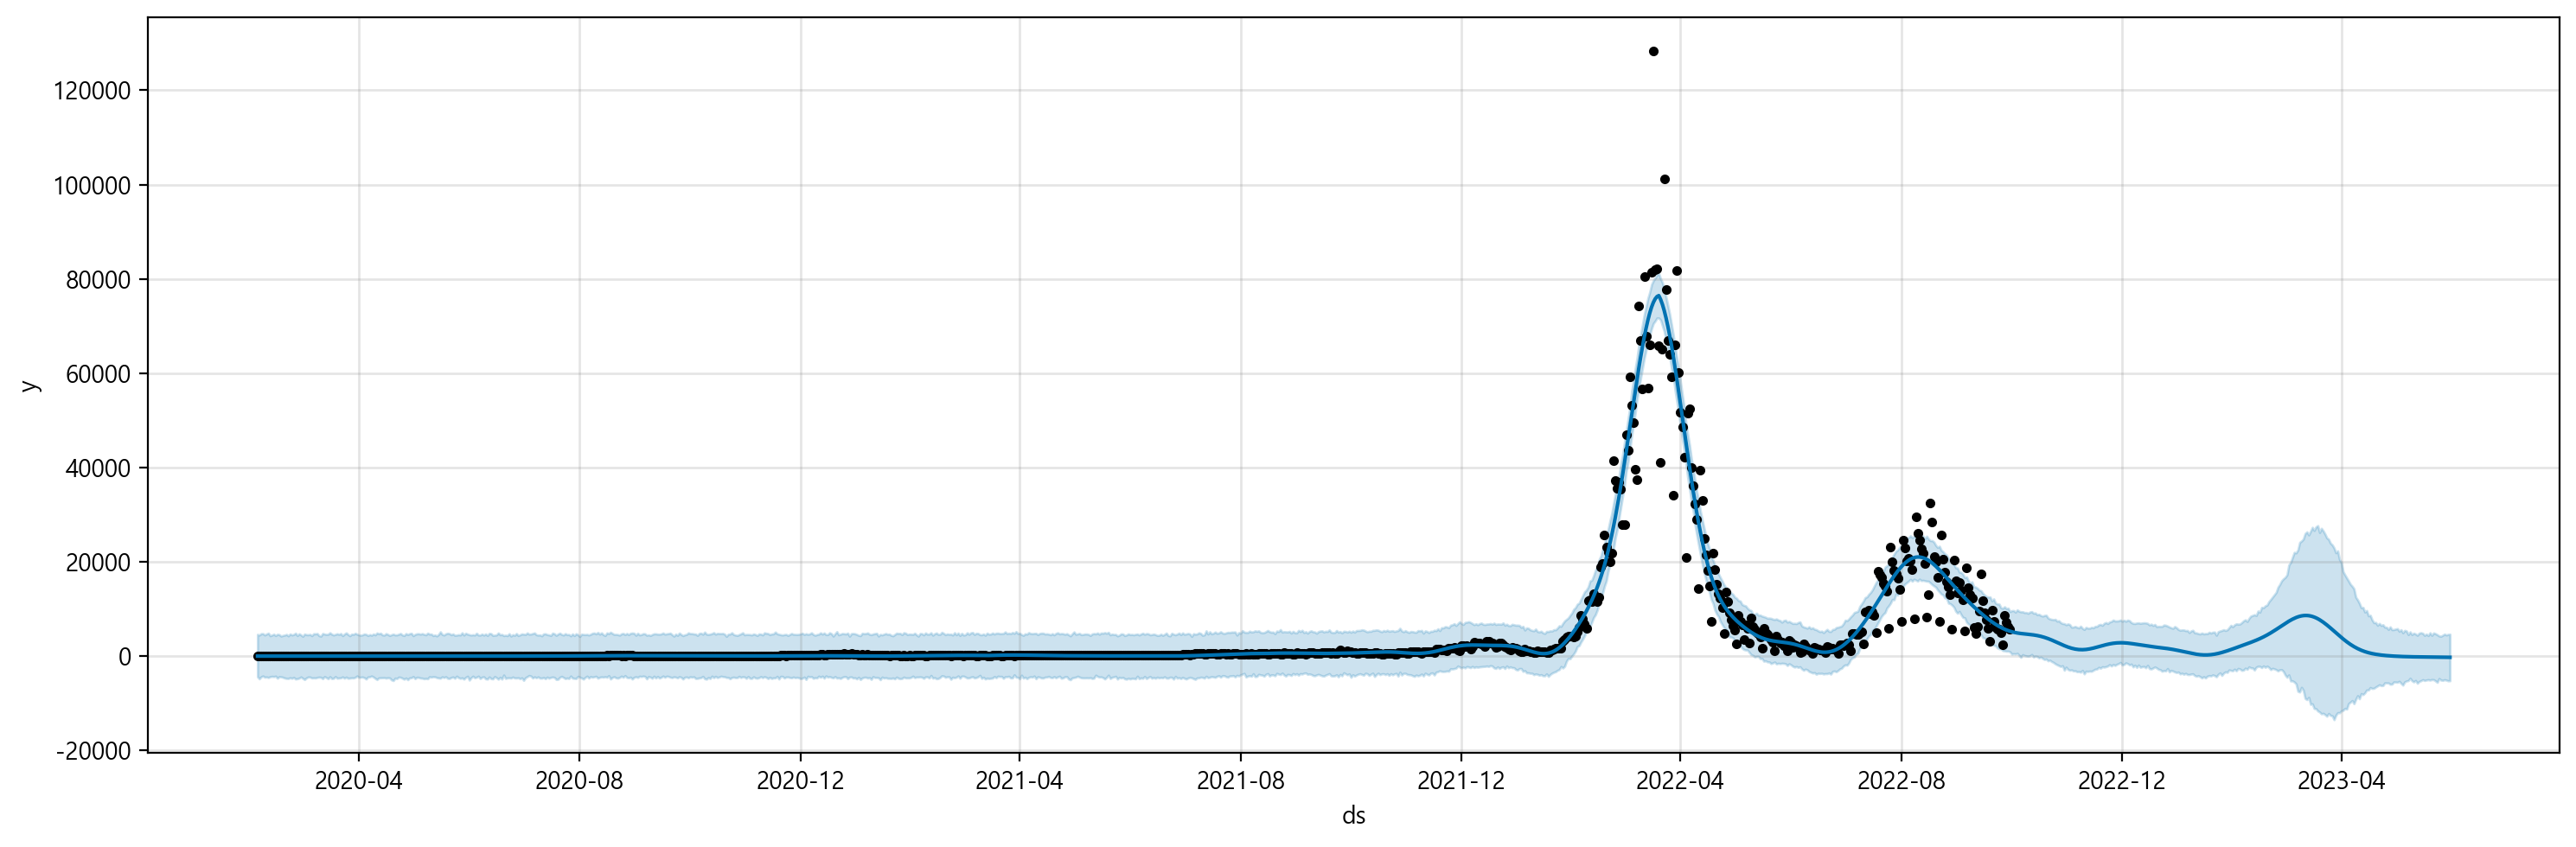

In [134]:
best_model = result_df.iloc[0]['model']
best_model.make_future_dataframe(periods=len(test)+7, freq='D')
forecast = best_model.predict(future)

fig = best_model.plot(forecast, figsize=(15, 5))

fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()